# 0. 필요한 모듈 불러오기

In [14]:
import math
import time
import datetime
from tqdm import tqdm
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 1. 데이터 처리

## 1-1. 데이터 불러오기


In [166]:
df = pd.read_csv('../data/rawData/rawData_utf.csv')
df['date'] = df['date'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568651 entries, 0 to 568650
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           568651 non-null  object 
 1   sd_nm          568651 non-null  object 
 2   sgg_nm         568651 non-null  object 
 3   tempAvg        568119 non-null  float64
 4   tempMin        568556 non-null  float64
 5   tempMax        568574 non-null  float64
 6   rain           210161 non-null  float64
 7   windMax        568339 non-null  float64
 8   windAvg        568192 non-null  float64
 9   humMin         568415 non-null  float64
 10  humAvg         567724 non-null  float64
 11  total_area     568470 non-null  float64
 12  field_area     568470 non-null  float64
 13  paddy_area     568470 non-null  float64
 14  cemetery_area  568470 non-null  float64
 15  population     568651 non-null  int64  
 16  occur          568651 non-null  int64  
dtypes: float64(12), int64(2), obj

## 1-2. 데이터 전처리
- 결측치 확인 및 제거
    - 강수량(rain) : 0
    - 토지 (total_area, field_area, paddy_area, cemetery_area): 동일 지역 전년도 값
    - 기온 (tempAvg, tempMin, tempMax): 동일 지역 같은 달의 평균
    - 습도 (humMin, humAvg): 동일 지역 같은 달의 평균
    - 풍속 (windMax, windAvg): 동일 지역 같은 달의 평균

In [167]:
{col:df[col].isnull().sum() for col in df.columns[df.isnull().sum() > 0].tolist()}

{'tempAvg': 532,
 'tempMin': 95,
 'tempMax': 77,
 'rain': 358490,
 'windMax': 312,
 'windAvg': 459,
 'humMin': 236,
 'humAvg': 927,
 'total_area': 181,
 'field_area': 181,
 'paddy_area': 181,
 'cemetery_area': 181}

In [168]:
# def fill_with_average(x):
#     return x.apply(lambda col: col.fillna(x[col.name].mean()))

filled_df = df.copy()
filled_df.insert(0, 'dateYear', filled_df['date'].str[:4])
filled_df.insert(1, 'dateMonth', filled_df['date'].str[4:6])
filled_df.insert(2, 'dateDay', filled_df['date'].str[6:])

filled_df.drop('date', axis=1)
# # 1월 ~ 6월까지만 추출
# filled_df = filled_df[filled_df['dateMonth'].isin(['01', '02', '03', '04', '05', '06'])]
filled_df['rain'] = filled_df['rain'].fillna(0)

weather_columns = ['tempAvg', 'tempMin', 'tempMax', 'windMax', 'windAvg', 'humMin', 'humAvg']

for col in weather_columns:
    filled_df[col].fillna(filled_df.groupby(['dateYear', 'dateMonth', 'sgg_nm'])[col].transform('mean'), inplace=True)

area_columns = ['total_area', 'field_area', 'paddy_area', 'cemetery_area']
for col in area_columns:
    filled_df[col] = filled_df.groupby('sgg_nm')[col].transform(lambda group: group.ffill().bfill())

data = filled_df.copy()
data['farm_ratio'] = (data['paddy_area'] + data['field_area']) / data['total_area']
data['cemetary_ratio'] = data['cemetery_area'] / data['total_area']
data['population_density'] = data['population'] / data['total_area']
data.insert(len(data.columns)-1, 'occur', data.pop('occur'))
data = data.drop(columns=['date', 'dateYear', 'dateMonth', 'dateDay', 'sgg_nm', 'field_area', 'paddy_area', 'cemetery_area', 'total_area', 'population'])

loc_datas = {do:None for do in data.sd_nm.unique()}

for do in loc_datas.keys():
    loc_df = data.copy()
    loc_df = loc_df[loc_df['sd_nm'] == do]
    loc_datas[do] = loc_df

data.head()

,sd_nm,tempAvg,tempMin,tempMax,rain,windMax,windAvg,humMin,humAvg,farm_ratio,cemetary_ratio,population_density,occur
0,경기도,25.4,20.2,32.3,0.0,3.9,1.6,46.0,71.8,0.082058,0.001393,0.009025,0
1,경기도,25.4,20.2,32.3,0.0,3.9,1.6,46.0,71.8,0.300796,0.000625,0.007117,0
2,경기도,25.4,20.2,32.3,0.0,3.9,1.6,46.0,71.8,0.050130,0.001093,0.015858,0
3,경기도,25.4,20.2,32.3,0.0,3.9,1.6,46.0,71.8,0.076241,0.002080,0.011764,0
4,경기도,26.0,21.1,31.2,0.0,4.4,2.1,44.0,67.8,0.129080,0.001359,0.004965,0


## 1-3. 데이터 시각화 

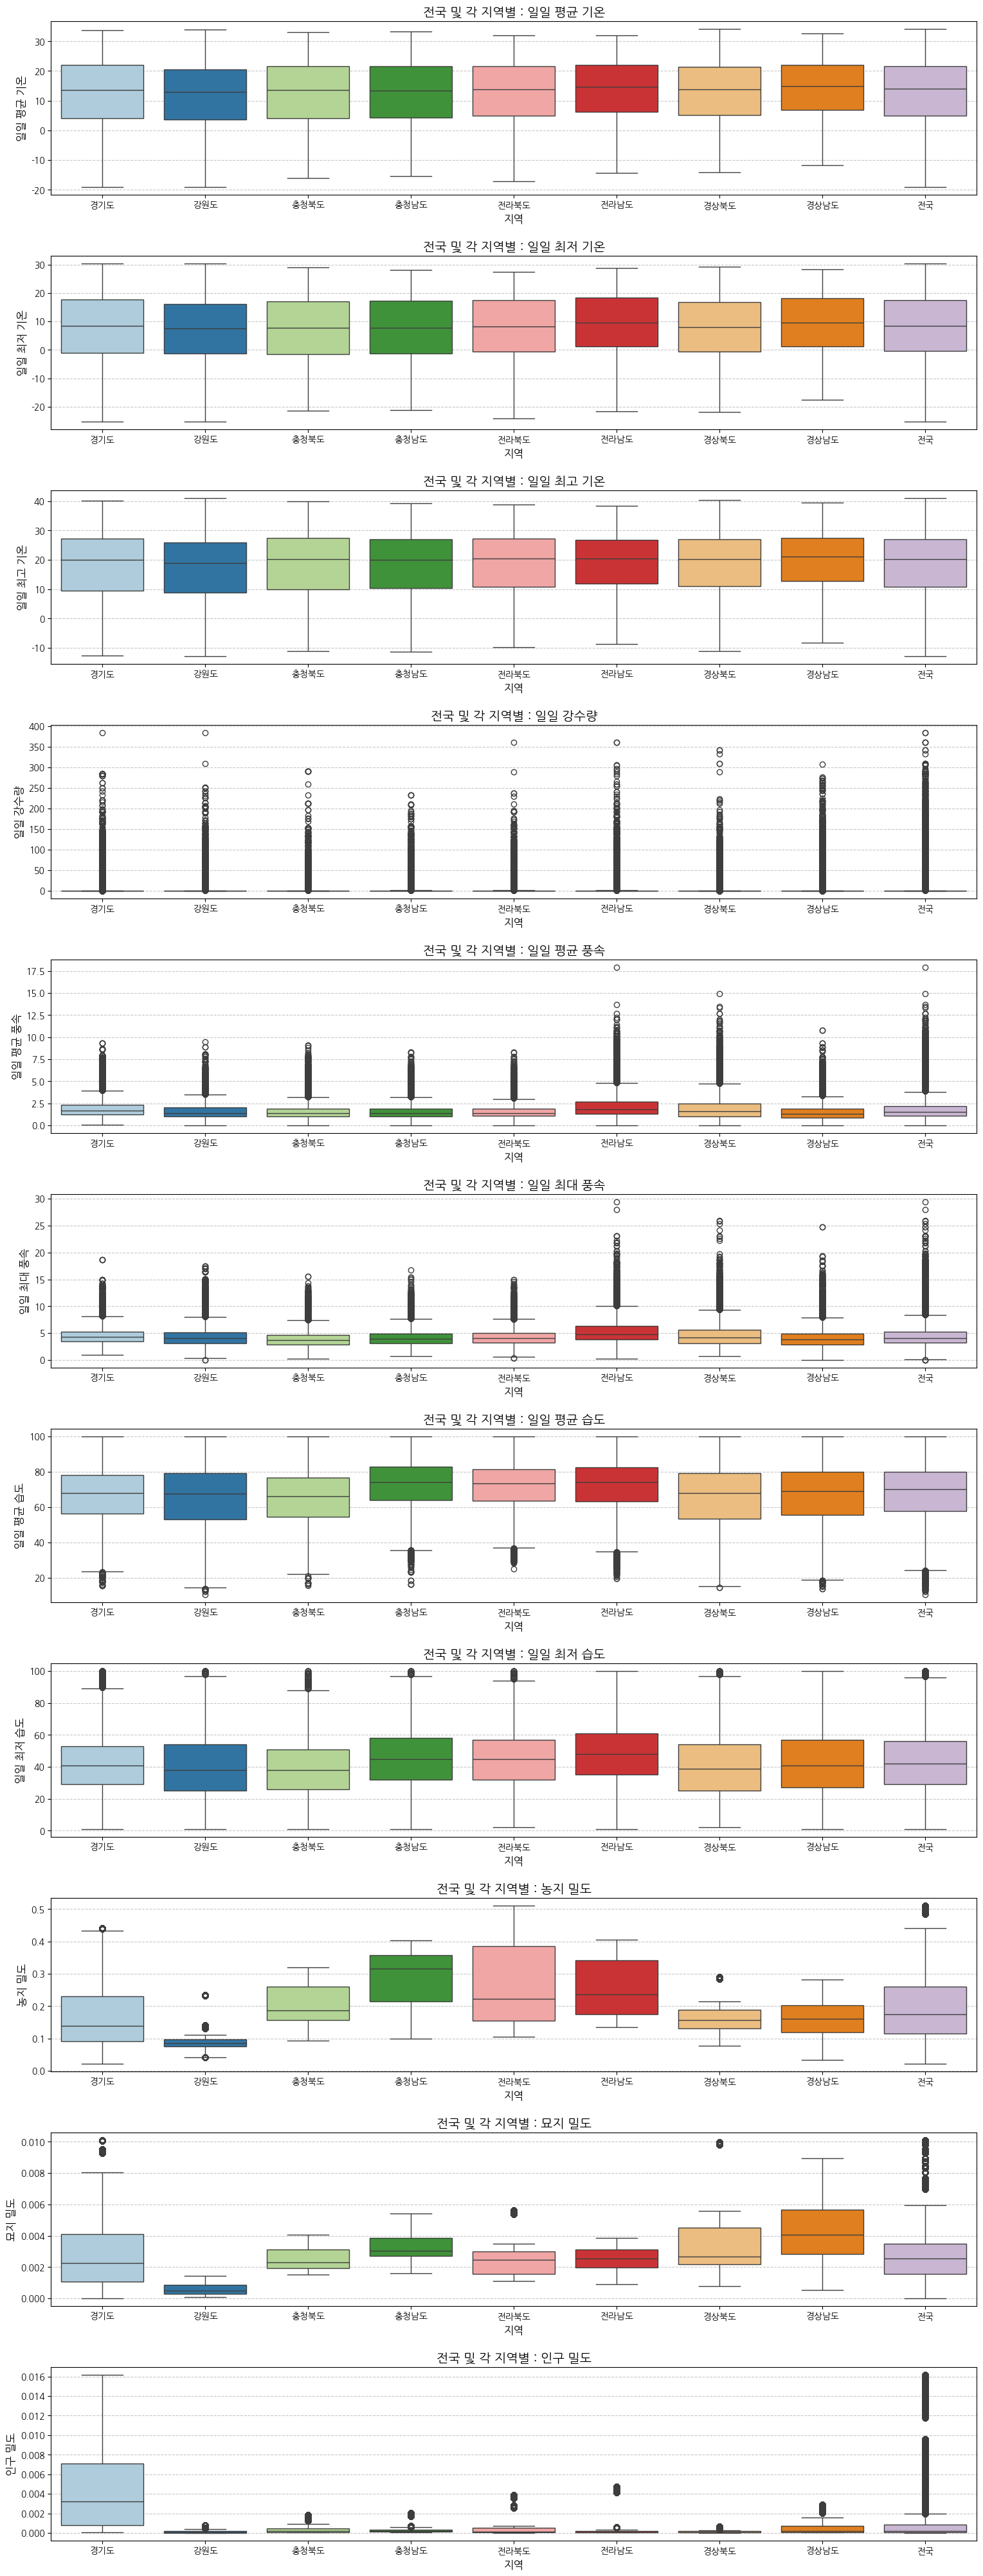

In [18]:
cols = {
    'tempAvg': '일일 평균 기온'
    , 'tempMin': '일일 최저 기온'
    , 'tempMax': '일일 최고 기온'
    , 'rain': '일일 강수량'
    , 'windAvg': '일일 평균 풍속'
    , 'windMax': '일일 최대 풍속'
    , 'humAvg': '일일 평균 습도'
    , 'humMin': '일일 최저 습도'
    , 'farm_ratio': '농지 밀도'
    , 'cemetary_ratio': '묘지 밀도'
    , 'population_density': '인구 밀도'
}

plt.figure(figsize=(18,49))

for idx, col in enumerate(cols.keys(), 1):
    tmp_data = data.copy()
    tmp_data['sd_nm'] = '전국'
    
    combined_data = pd.concat([data, tmp_data])
    
    plt.subplot(11,1,idx)
    sns.boxplot(x='sd_nm', y=col, data=combined_data, hue='sd_nm', palette='Paired')
    
    plt.title(f'전국 및 각 지역별 : {cols[col]}', fontsize=14)
    plt.xlabel('지역', fontsize=12)
    plt.ylabel(cols[col], fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
plt.subplots_adjust(hspace=0.35, wspace=0.3, top=0.9, bottom=0.1, left=0.1, right=0.9)
plt.show()

In [180]:
def drawChart(target_col, col_name, total_data=data):
    tmp_data = total_data.copy()
    tmp_data['sd_nm'] = '전국'
    
    combined = pd.concat([total_data, tmp_data])
    
    plt.figure(figsize=(18, 3))
    sns.boxplot(x='sd_nm', y=target_col, data=combined, hue='sd_nm', palette='Paired')
    
    plt.title(f'전국 및 각 지역별 : {col_name}', fontsize=14)
    plt.xlabel('지역', fontsize=12)
    plt.ylabel(col_name, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()


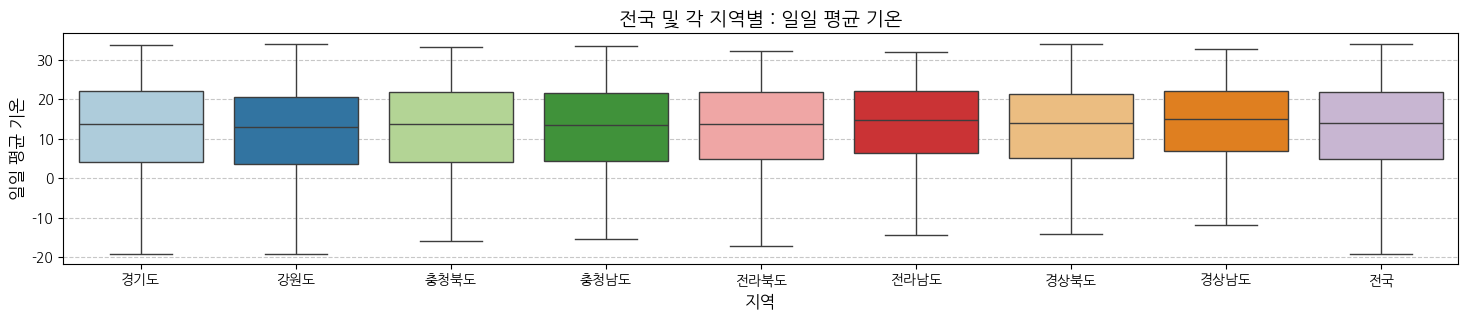

In [181]:
drawChart('tempAvg', '일일 평균 기온')

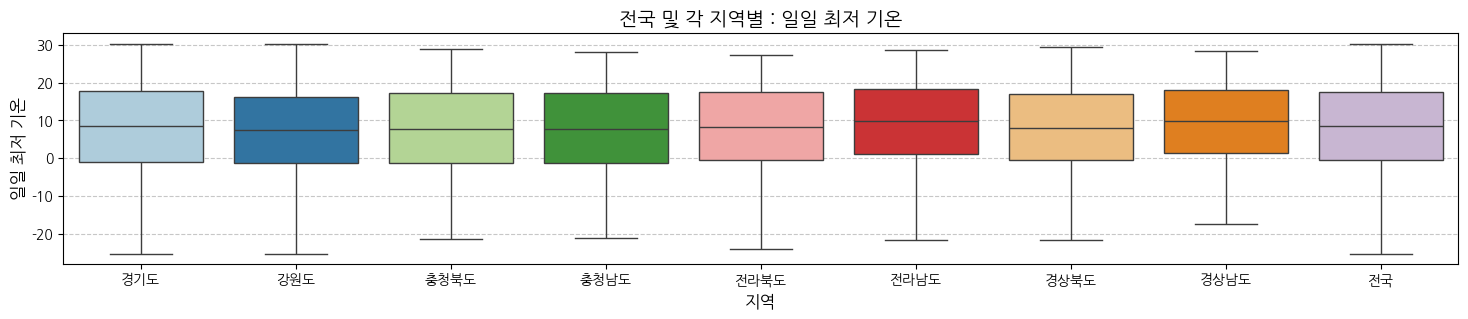

In [182]:
drawChart('tempMin', '일일 최저 기온')

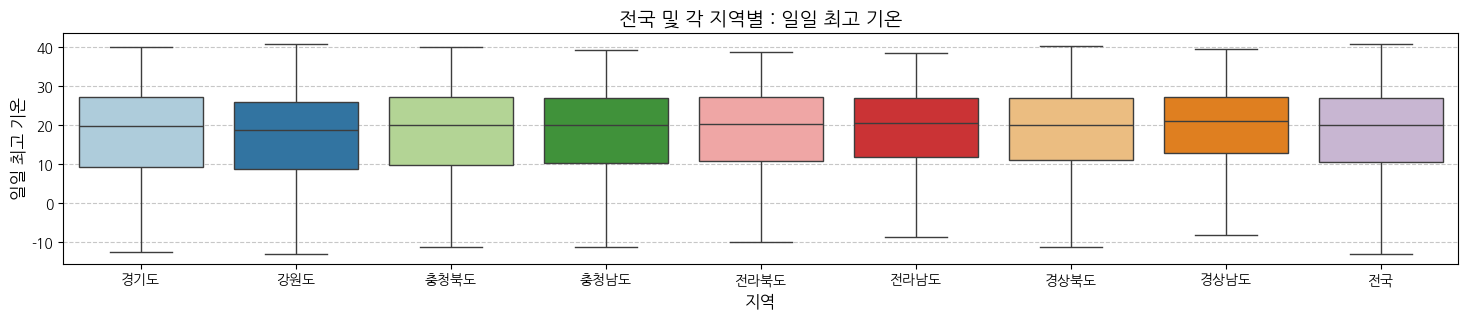

In [183]:
drawChart('tempMax', '일일 최고 기온')

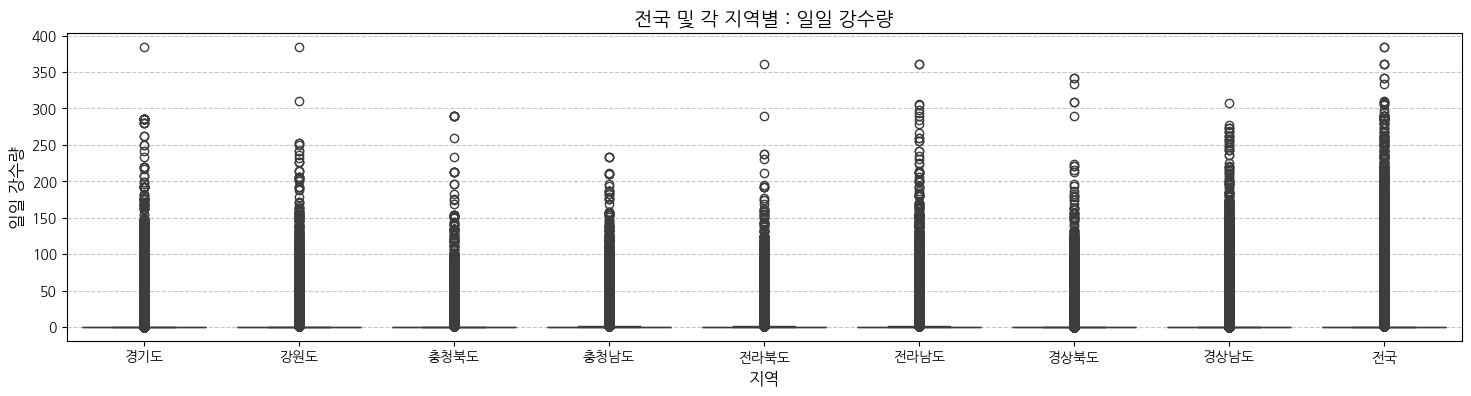

In [172]:
drawChart('rain', '일일 강수량')

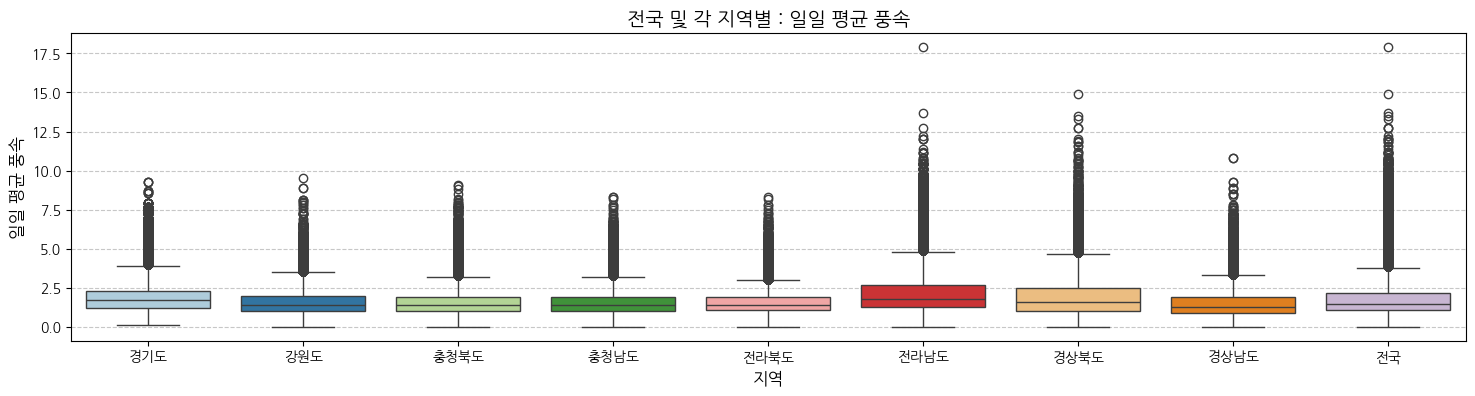

In [173]:
drawChart('windAvg', '일일 평균 풍속')

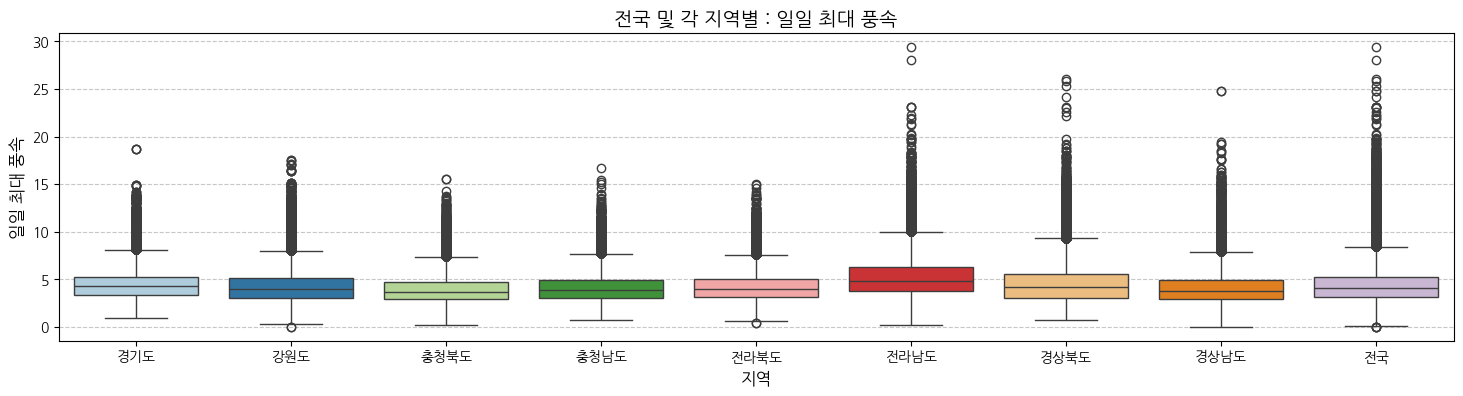

In [174]:
drawChart('windMax', '일일 최대 풍속')

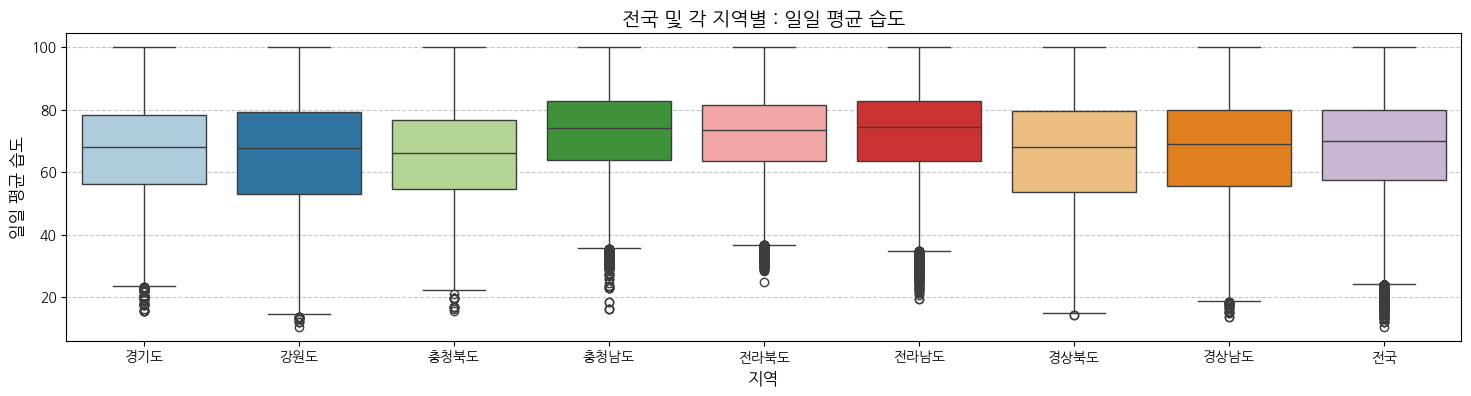

In [175]:
drawChart('humAvg', '일일 평균 습도')

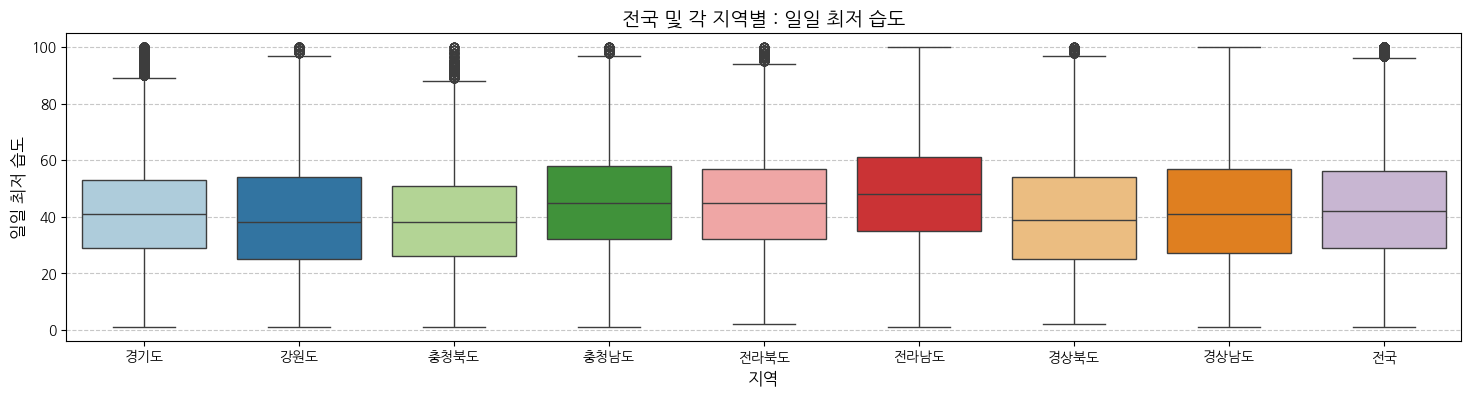

In [176]:
drawChart('humMin', '일일 최저 습도')

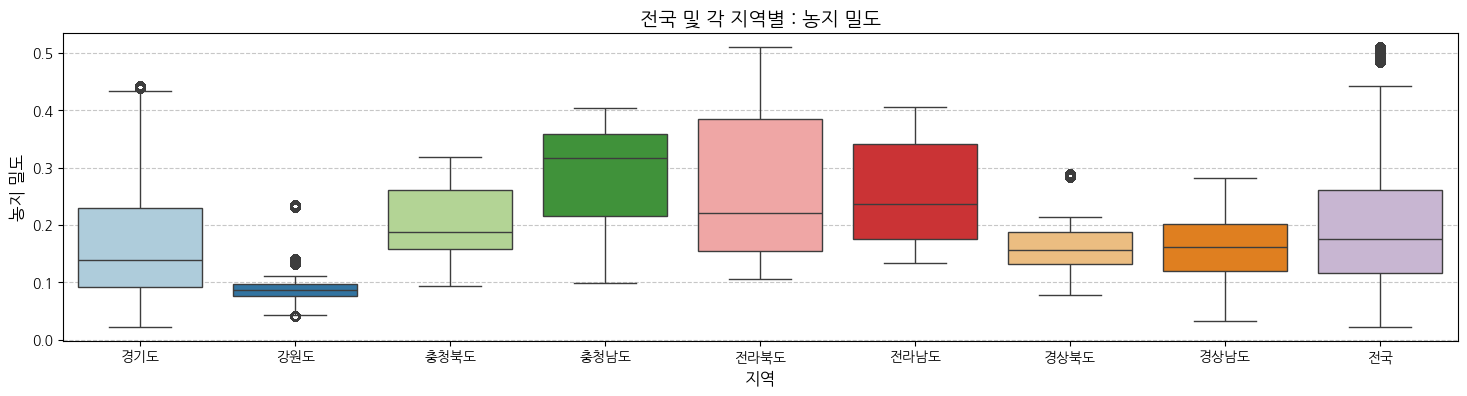

In [177]:
drawChart('farm_ratio', '농지 밀도')

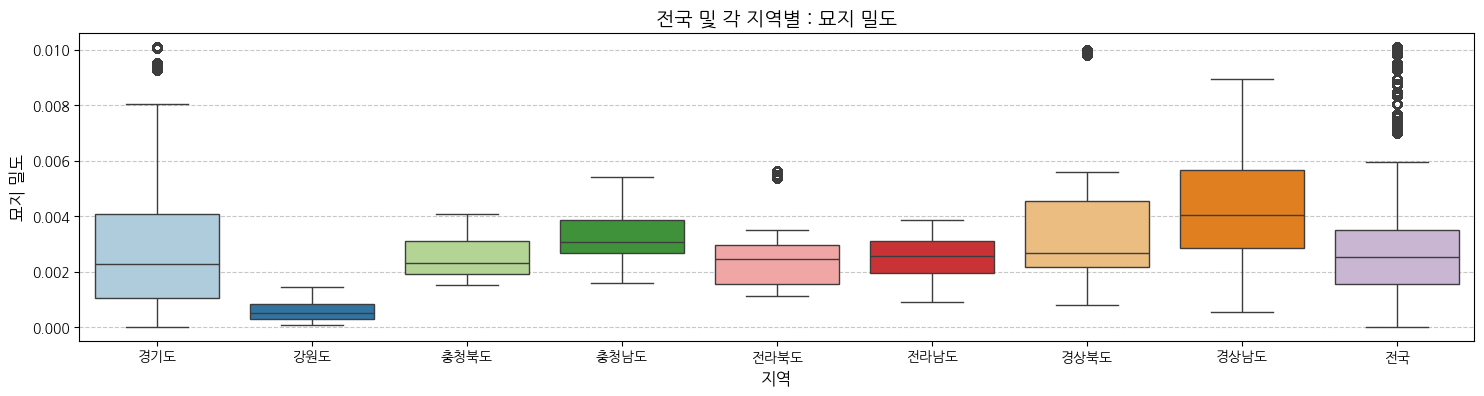

In [178]:
drawChart('cemetary_ratio', '묘지 밀도')

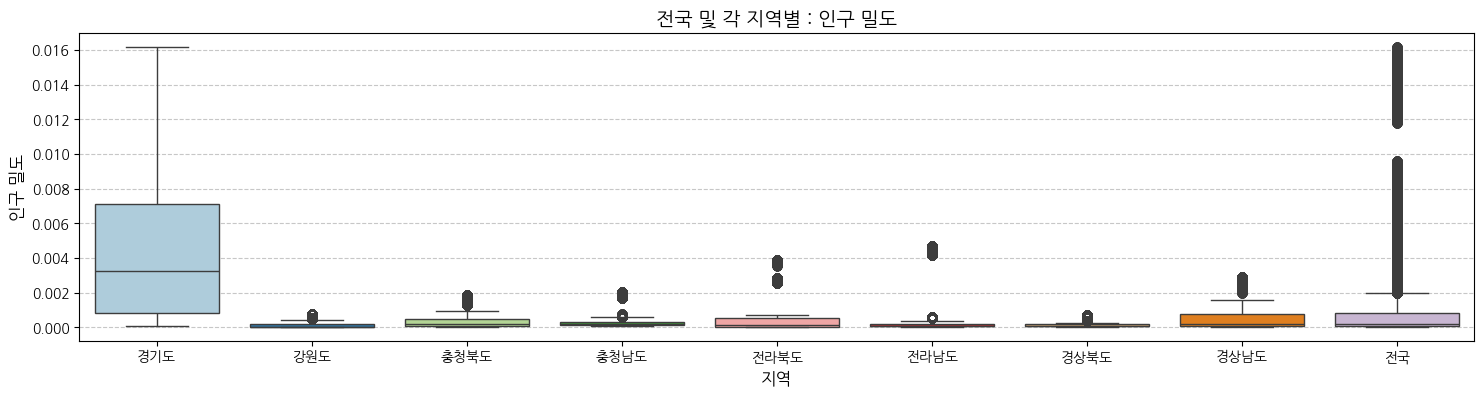

In [179]:
drawChart('population_density', '인구 밀도')

- 데이터 불균형 확인

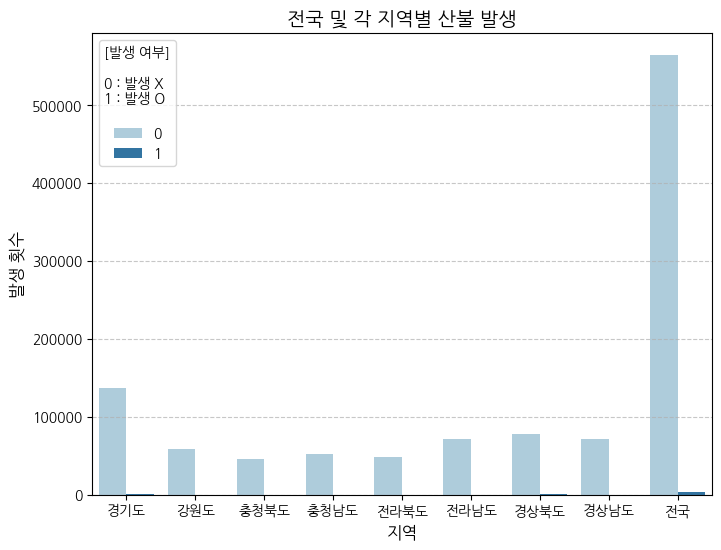

In [20]:
tmp_data = data.copy()
tmp_data['sd_nm'] = '전국'
combined_data = pd.concat([data, tmp_data])

plt.figure(figsize=(8, 6))
sns.countplot(x='sd_nm', hue='occur', data=combined_data, palette='Paired')
plt.title('전국 및 각 지역별 산불 발생', fontsize=14)
plt.xlabel('지역', fontsize=12)
plt.ylabel('발생 횟수', fontsize=12)
plt.legend(title='[발생 여부]\n\n0 : 발생 X\n1 : 발생 O\n')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. 모델 학습

- 머신러닝 관련 패키지 Import

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_curve, auc as metrics_auc,
                             precision_recall_curve, precision_score, recall_score, roc_auc_score)


## 2-0. 데이터 분류 및 오버 샘플링(SMOTE)

In [22]:
def DataProcessing(input_data):
    ml_data = input_data.copy()
    ml_data_X = ml_data.drop(['sd_nm', 'occur'], axis=1)
    ml_data_Y = ml_data['occur']
    
    X_train, X_test, Y_train, Y_test = train_test_split(ml_data_X, ml_data_Y, test_size=0.2, random_state=42)
    
    # SMOTE 적용
    smote = SMOTE(random_state=42)
    X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
    
    # 스케일링 적용
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, Y_train_resampled, X_test_scaled, Y_test

## 2-1. 모델 학습 및 평가

In [24]:
def EvaluateModel(model, param_grid, xtrain, ytrain, xtest, ytest):
    """
    모델을 학습시키고 최적 하이퍼파라미터를 찾은 후 평가 및 시각화를 수행하는 함수

    Args:
    - model: 머신러닝 모델
    - param_grid: 하이퍼파라미터 그리드
    - xtrain, ytrain: 학습 데이터
    - xtest, ytest: 테스트 데이터
    - model_name: 모델 이름 (str)

    Returns:
    - best_model: 최적의 하이퍼파라미터를 가진 모델
    """
    
    grid_search = GridSearchCV(
        model
        , param_grid
        , cv=5
        , scoring=['roc_auc', 'average_precision']
        , refit='average_precision'
        , n_jobs=-1
        # , verbose=1
    )
    grid_search.fit(xtrain, ytrain)

    # 최적 모델 가져오기
    best_model = grid_search.best_estimator_
    
    # 2. 예측 수행
    Y_pred = best_model.predict(xtest)
    Y_pred_proba = best_model.predict_proba(xtest)[:, 1]
    
    # 3. 평가 지표 계산
    metrics = {
        'best_params': grid_search.best_params_
        , 'accuracy': accuracy_score(ytest, Y_pred)
        , 'precision': precision_score(ytest, Y_pred)
        , 'recall': recall_score(ytest, Y_pred)
        , 'roc_auc': roc_auc_score(ytest, Y_pred_proba)
        , 'confusion_matrix': confusion_matrix(ytest, Y_pred)
        , 'fpr_vals': roc_curve(ytest, Y_pred_proba)[0]
        , 'tpr_vals': roc_curve(ytest, Y_pred_proba)[1]
        , 'precision_vals': precision_recall_curve(ytest, Y_pred_proba)[0]
        , 'recall_vals': precision_recall_curve(ytest, Y_pred_proba)[1]
        , 'pr_auc': metrics_auc(precision_recall_curve(ytest, Y_pred_proba)[1], precision_recall_curve(ytest, Y_pred_proba)[0])
    }
    
    return metrics

### 2-1-0. 활용 모델 및 하이퍼 파라미터 지정

In [36]:
model_params_dict = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100]
        },
        'color': 'blue'
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'params': {
            'n_estimators': [100, 300, 500]
            , 'max_depth': [3, 6, 9]
            , 'learning_rate': [0.01, 0.1, 0.2]
            # , 'tree_method': ['gpu_hist']
            # , 'gpu_id': [0]
        },
        'color': 'red'
    },
    'LGBMClassifier': {
        'model': LGBMClassifier(),
        'params': {
            'n_estimators': [100, 300, 500]
            , 'num_leaves': [31, 63, 127]
            , 'learning_rate': [0.01, 0.1, 0.2]
            # , 'device': ['gpu']
        },
        'color': 'purple'
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 300, 500]
            , 'max_depth': [None, 10, 20, 30]
            , 'min_samples_leaf': [2, 5, 10]
        },
        'color': 'green'
    }
}

### 2-1-1. 지역별 모델 학습 및 평가

In [ ]:
# 지역별 데이터
loc_results = dict()

for loc, loc_data in loc_datas.items():
    tmp_dict = dict()
    
    x_loc_train, y_loc_train, x_loc_test, y_loc_test = DataProcessing(loc_data)
    
    for model in model_params_dict.keys():
        print(f'{loc} - {model} Start : {datetime.datetime.now()}')
        tmp_dict[model] = EvaluateModel(
                            model = model_params_dict[model]['model']
                            , param_grid = model_params_dict[model]['params']
                            , xtrain = x_loc_train
                            , ytrain = y_loc_train
                            , xtest = x_loc_test
                            , ytest = y_loc_test
        )
        print(f'{loc} - {model} Finish : {datetime.datetime.now()}')
    
    loc_results[loc] = tmp_dict

경기도 - LogisticRegression Start : 2025-02-02 14:04:17.303595
경기도 - LogisticRegression Finish : 2025-02-02 14:04:21.330957
경기도 - XGBClassifier Start : 2025-02-02 14:04:21.330957
경기도 - XGBClassifier Finish : 2025-02-02 14:05:35.017979
경기도 - LGBMClassifier Start : 2025-02-02 14:05:35.017979
[LightGBM] [Info] Number of positive: 109541, number of negative: 109541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 219082, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
경기도 - LGBMClassifier Finish : 2025-02-02 14:08:39.798445
경기도 - RandomForestClassifier Start : 2025-02-02 14:08:39.798445
경기도 - RandomForestClassifier Finish : 2025-02-02 14:57:21.815131
강원도 - LogisticRegression Start : 2025-02-02 14:57:21.865862
강원도 - LogisticRegression

In [ ]:
region_result_df = pd.DataFrame(
    {(region, model): metrics for region, models in loc_results.items() for model, metrics in models.items()}
).T

region_result_df.index.names = ["Region", "Model"]
region_result_df.to_csv('../result/region_result.csv')

region_result_df.insert(1, 'true_negative', region_result_df['confusion_matrix'].apply(lambda x: x[0][0]))
region_result_df.insert(2, 'fale_positive', region_result_df['confusion_matrix'].apply(lambda x: x[0][1]))
region_result_df.insert(3, 'fale_negative', region_result_df['confusion_matrix'].apply(lambda x: x[1][0]))
region_result_df.insert(4, 'true_positive', region_result_df['confusion_matrix'].apply(lambda x: x[1][1]))

filt_region_result_df = region_result_df.copy()
filt_region_result_df = filt_region_result_df.drop(['best_params','confusion_matrix'] + [col for col in region_result_df.columns if col.endswith('vals')], axis=1)

filt_region_result_df.to_csv('../result/region_result_filt.csv')
filt_region_result_df

true_negative  fale_positive  fale_negative  \
Region Model                                                                 
경기도    LogisticRegression              20741           6630             44   
       XGBClassifier                   27330             41            231   
       LGBMClassifier                  27348             23            233   
       RandomForestClassifier          27273             98            224   
강원도    LogisticRegression               8493           3193             27   
       XGBClassifier                   11660             26            145   
       LGBMClassifier                  11672             14            147   
       RandomForestClassifier          11646             40            141   
충청북도   LogisticRegression               7121           2035              5   
       XGBClassifier                    9144             12             48   
       LGBMClassifier                   9151              5             48   
       RandomForestClassifier           9144             12             48   
충청남도   LogisticRegression               7845           2609             13   
       XGBClassifier                   10444             10             64   
       LGBMClassifier                  10452              2             65   
       RandomForestClassifier          10445              9             65   
전라북도   LogisticRegression               7551           2263             11   
       XGBClassifier                    9807              7             46   
       LGBMClassifier                   9809              5             47   
       RandomForestClassifier           9807              7             47   
전라남도   LogisticRegression              10422           3979             17   
       XGBClassifier                   14392              9             62   
       LGBMClassifier                  14397              4             62   
       RandomForestClassifier          14391             10             62   
경상북도   LogisticRegression              10761           4866             37   
       XGBClassifier                   15613             14            149   
       LGBMClassifier                  15620              7            151   
       RandomForestClassifier          15594             33            151   
경상남도   LogisticRegression              10211           4176             18   
       XGBClassifier                   14376             11             75   
       LGBMClassifier                  14382              5             76   
       RandomForestClassifier          14372             15             75   

                               true_positive  accuracy precision    recall  \
Region Model                                                                 
경기도    LogisticRegression                196  0.758285  0.028714  0.816667   
       XGBClassifier                       9  0.990149      0.18    0.0375   
       LGBMClassifier                      7  0.990728  0.233333  0.029167   
       RandomForestClassifier             16  0.988338  0.140351  0.066667   
강원도    LogisticRegression                121  0.727903  0.036512  0.817568   
       XGBClassifier                       3   0.98555  0.103448   0.02027   
       LGBMClassifier                      1  0.986395  0.066667  0.006757   
       RandomForestClassifier              7  0.984705  0.148936  0.047297   
충청북도   LogisticRegression                 43  0.778357  0.020693  0.895833   
       XGBClassifier                       0  0.993481       0.0       0.0   
       LGBMClassifier                      0  0.994242       0.0       0.0   
       RandomForestClassifier              0  0.993481       0.0       0.0   
충청남도   LogisticRegression                 52  0.750737  0.019542       0.8   
       XGBClassifier                       1  0.992965  0.090909  0.015385   
       LGBMClassifier                      0  0.993631       0.0       0.0   
       RandomForestClassifier              0  0.9929

### 2-1-2. 전국 모델 학습 및 평가

In [134]:
# 전국 데이터
nat_results = dict()

x_train, y_train, x_test, y_test = DataProcessing(data)

for model in model_params_dict.keys():
    print(f'{model} Start : {datetime.datetime.now()}')
    nat_results[model] = EvaluateModel(
                        model = model_params_dict[model]['model']
                        , param_grid = model_params_dict[model]['params']
                        , xtrain = x_train
                        , ytrain = y_train
                        , xtest = x_test
                        , ytest = y_test
    )
    print(f'{model} Finish : {datetime.datetime.now()}')

LogisticRegression Start : 2025-02-02 18:40:46.188894
LogisticRegression Finish : 2025-02-02 18:41:06.311057
XGBClassifier Start : 2025-02-02 18:41:06.311057
XGBClassifier Finish : 2025-02-02 18:45:39.447310
LGBMClassifier Start : 2025-02-02 18:45:39.448311
[LightGBM] [Info] Number of positive: 451549, number of negative: 451549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 903098, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBMClassifier Finish : 2025-02-02 18:53:15.478454
RandomForestClassifier Start : 2025-02-02 18:53:15.478454
RandomForestClassifier Finish : 2025-02-02 23:38:17.294232


In [145]:
nation_result_df = pd.DataFrame(
    {model: metrics for model, metrics in nat_results.items()}
).T

nation_result_df.index.names = ["Model"]
nation_result_df
nation_result_df.to_csv('../result/nation_result.csv')

nation_result_df.insert(1, 'true_negative', nation_result_df['confusion_matrix'].apply(lambda x: x[0][0]))
nation_result_df.insert(2, 'fale_positive', nation_result_df['confusion_matrix'].apply(lambda x: x[0][1]))
nation_result_df.insert(3, 'fale_negative', nation_result_df['confusion_matrix'].apply(lambda x: x[1][0]))
nation_result_df.insert(4, 'true_positive', nation_result_df['confusion_matrix'].apply(lambda x: x[1][1]))

nation_result_df = nation_result_df.copy()
filt_nation_result_df = nation_result_df.drop(['best_params','confusion_matrix'] + [col for col in nation_result_df.columns if col.endswith('vals')], axis=1)

filt_nation_result_df.to_csv('../result/nation_result_filt.csv')
filt_nation_result_df

,true_negative,fale_positive,fale_negative,true_positive,accuracy,precision,recall,roc_auc,pr_auc
Model,,,,,,,,,
LogisticRegression,81556,31296,189,690,0.723163,0.021572,0.784983,0.829238,0.040599
XGBClassifier,112785,67,871,8,0.991752,0.106667,0.009101,0.812725,0.039693
LGBMClassifier,112786,66,877,2,0.991709,0.029412,0.002275,0.82206,0.039865
RandomForestClassifier,112538,314,852,27,0.989748,0.079179,0.030717,0.795648,0.032937


## 2-2. 평가 결과 시각화

### 2-2-1. 지역별 모델 평가 시각화

- ROC-AUC

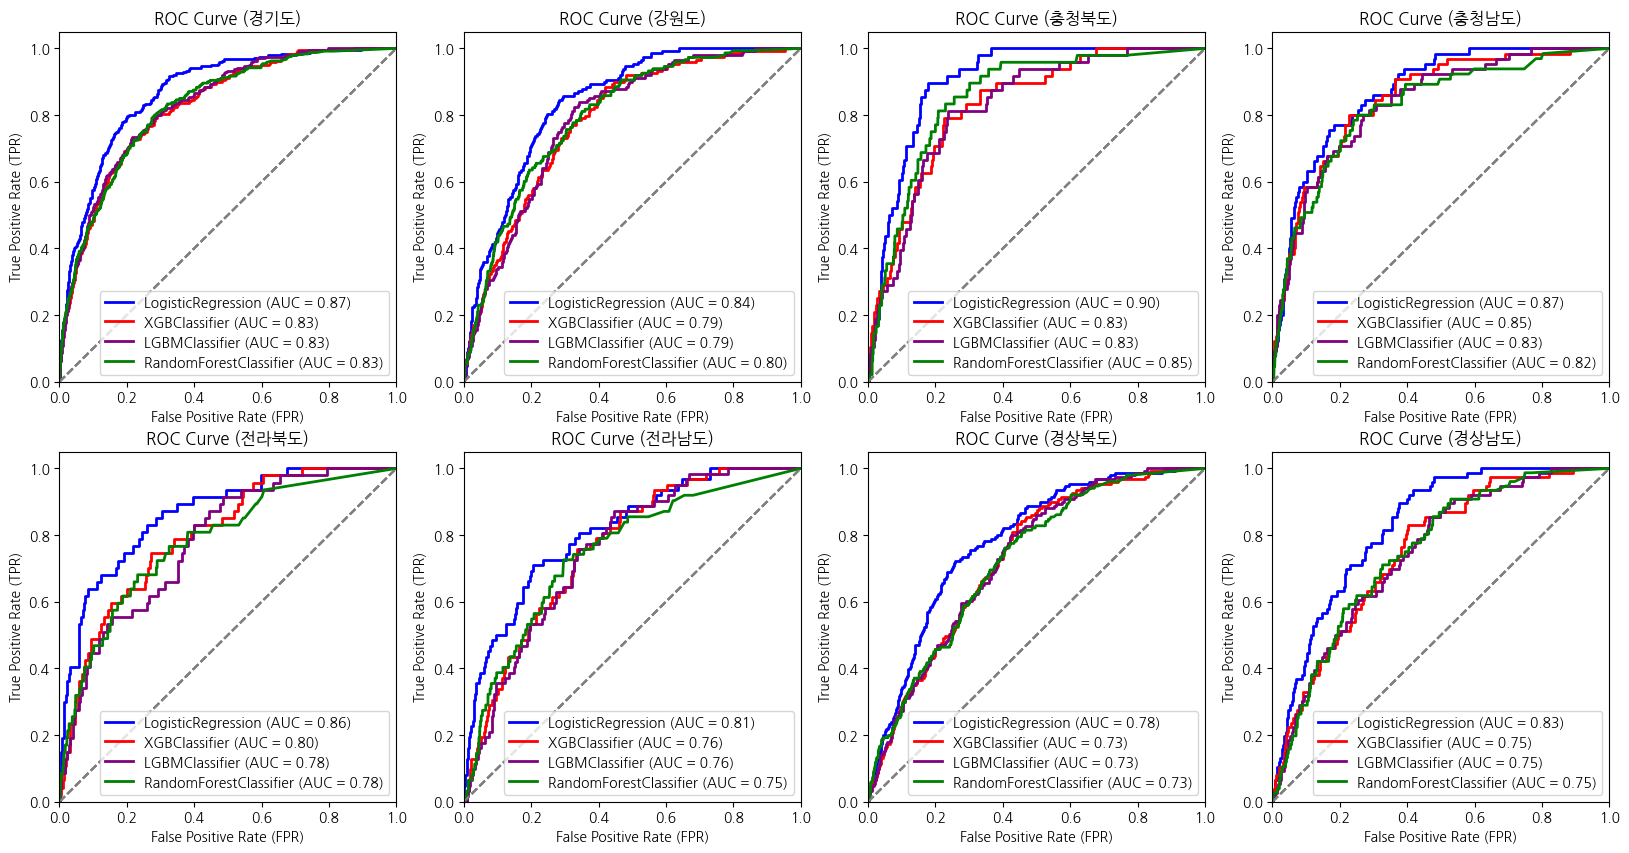

In [ ]:
plt.figure(figsize=(20, 10))

for idx, (r, m) in enumerate(region_result_df.index):
    if idx % 4 == 0:
        plt.subplot(2,4,(idx//4 +1))
    else:
        pass

    plt.plot(
        region_result_df.loc[(r, m), 'fpr_vals']
        , region_result_df.loc[(r, m), 'tpr_vals']
        , color=model_params_dict[m]['color']
        , lw=2
        , label=f"{m} (AUC = {region_result_df.loc[(r, m), 'roc_auc']:.2f})"
    )
            
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC Curve ({r})")
    plt.legend(loc="lower right")
    plt.grid()

plt.show()

- PR-AUC

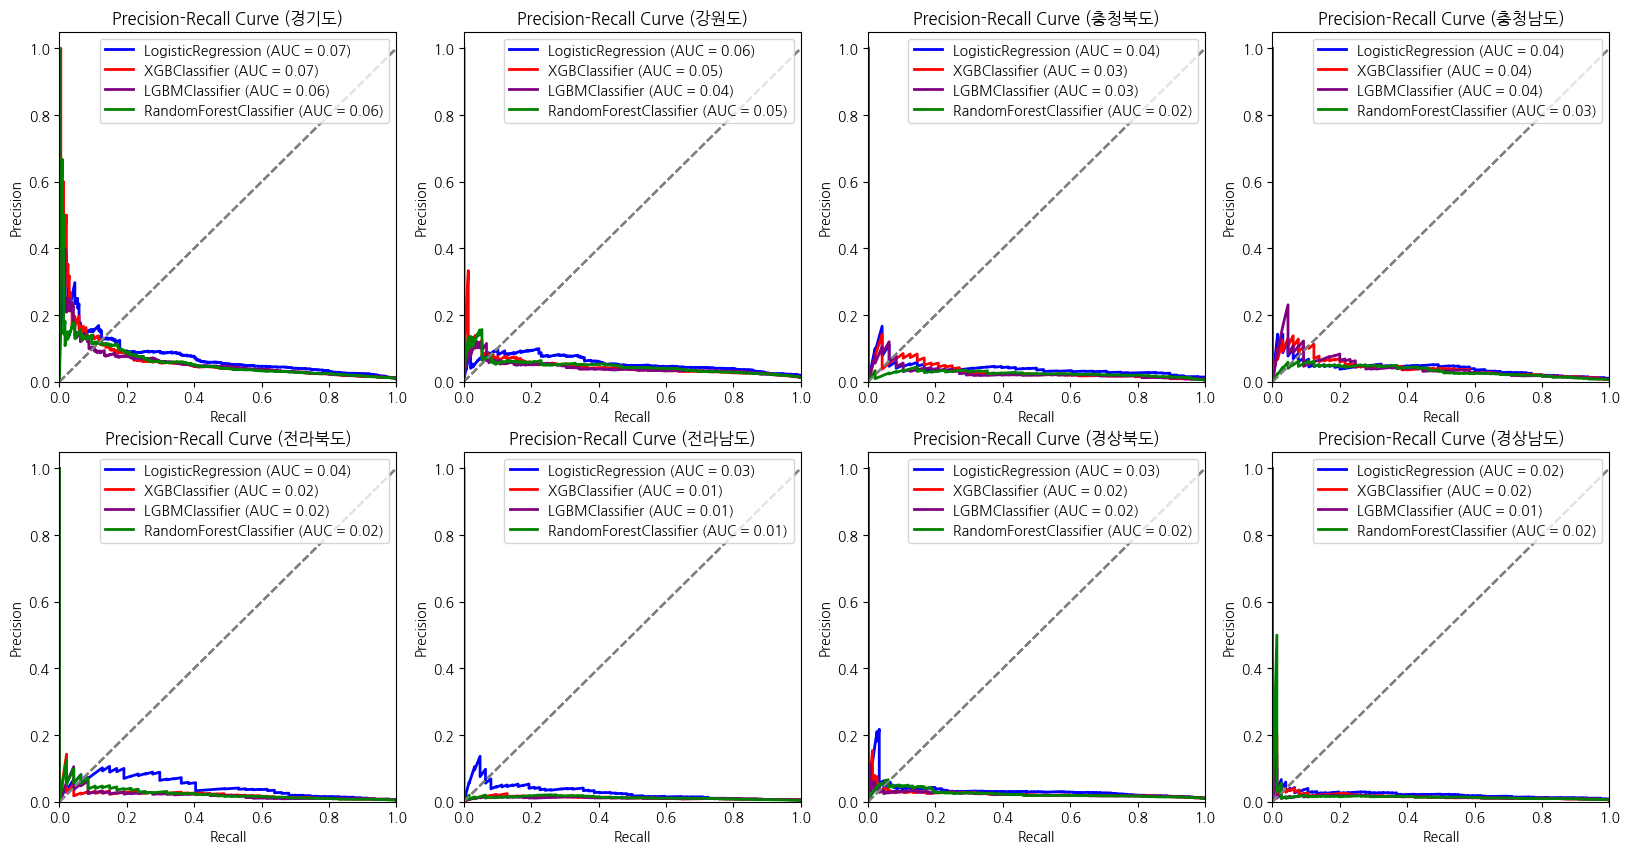

In [ ]:
plt.figure(figsize=(20, 10))

for idx, (r, m) in enumerate(region_result_df.index):
    if idx % 4 == 0:
        plt.subplot(2,4,(idx//4 +1))
    else:
        pass

    plt.plot(
        region_result_df.loc[(r, m), 'recall_vals']
        , region_result_df.loc[(r, m), 'precision_vals']
        , color=model_params_dict[m]['color']
        , lw=2
        , label=f"{m} (AUC = {region_result_df.loc[(r, m), 'pr_auc']:.2f})"
    )
            
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({r})")
    plt.legend(loc="upper right")
    plt.grid()

plt.show()

### 2-2-2. 전국 모델 평가 시각화

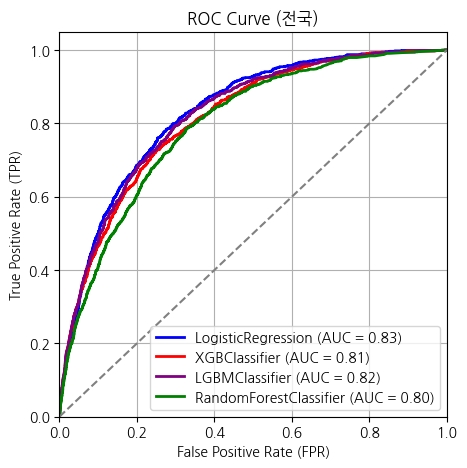

In [162]:
# ROC Curve
plt.figure(figsize=(5, 5))

for m in nation_result_df.index:
    plt.plot(
        nation_result_df.loc[m, 'fpr_vals']
        , nation_result_df.loc[m, 'tpr_vals']
        , color=model_params_dict[m]['color']
        , lw=2
        , label=f"{m} (AUC = {nation_result_df.loc[m, 'roc_auc']:.2f})"
    )
            
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title(f"ROC Curve (전국)")
plt.legend(loc="lower right")
plt.grid()

plt.show()

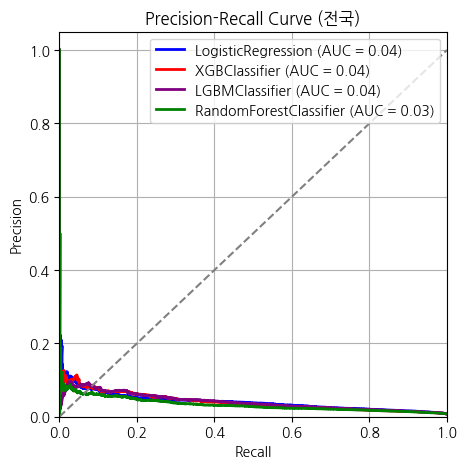

In [163]:
# Precision-Recall Curve
plt.figure(figsize=(5, 5))

for m in nation_result_df.index:
    plt.plot(
        nation_result_df.loc[m, 'recall_vals']
        , nation_result_df.loc[m, 'precision_vals']
        , color=model_params_dict[m]['color']
        , lw=2
        , label=f"{m} (AUC = {nation_result_df.loc[m, 'pr_auc']:.2f})"
    )
        
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (전국)")
plt.legend(loc="upper right")
plt.grid()

plt.show()